In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from choropleth_functions import *

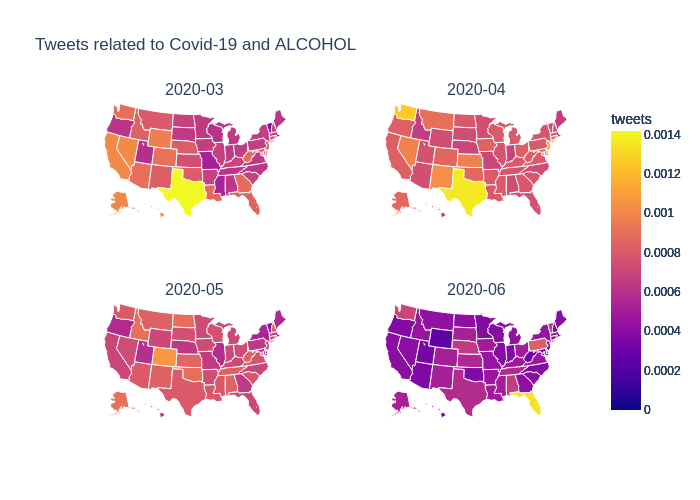

In [3]:
dates = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06']
dates2 = ['2020-03', '2020-04', '2020-05', '2020-06']

# plotty_plots(kw, dates, renderer = 'png', rows = 2, cols = 3, savefig = False):
plotty_plots('ALCOHOL', dates2, rows = 2, cols = 2)#, renderer='firefox')

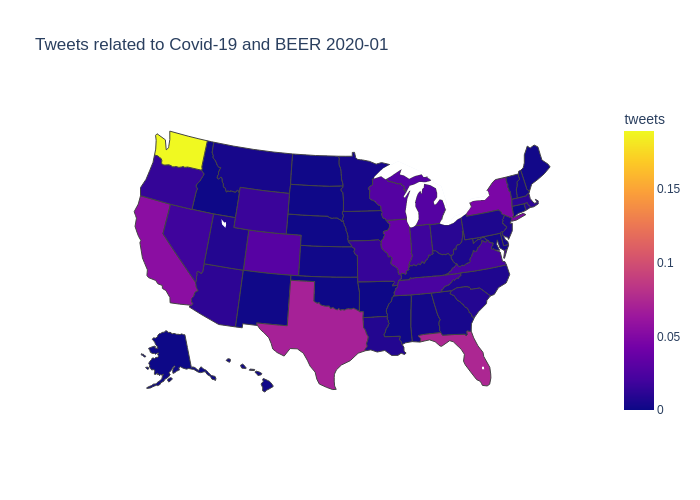

In [5]:
plotty('BEER', '2020-01')
#plotty_w('WINE', '1')